[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745), (0.21568627450980393, 0.49411764705882355, 0.7215686274509804)]
[(0.21568627450980393, 0.49411764705882355, 0.7215686274509804), (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]
0.5789473684210527
0.8058608058608059


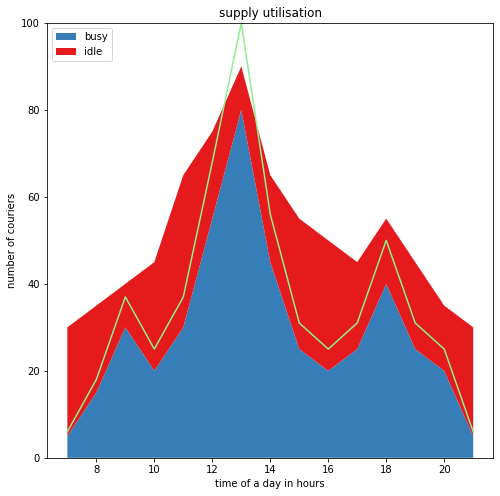

In [161]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

hours = np.arange(7, 22)
busy = np.array([ 5, 15, 30, 20, 30, 55, 80, 45, 25, 20, 25, 40, 25, 20, 5])
idle = np.array([25, 20, 10, 25, 35, 20, 10, 20, 30, 30, 20, 15, 20, 15, 25])
optimal = (busy / 0.8).astype(np.int)

_, ax = plt.subplots(figsize = (8, 8))
ax.set_title('supply utilisation') 
ax.set_xlabel('time of a day in hours') 
ax.set_ylabel('number of couriers') 
ax.set_ylim(0, np.max(np.add(idle, busy)) + 10)
palette = sns.color_palette("Set1")
print(palette[:2])
print(palette[:2][::-1])
ax.stackplot(hours, busy, idle, labels = ['busy', 'idle'], colors = palette[:2][::-1])
ax.plot(hours, optimal, color = 'lightgreen')
ax.legend(loc = 'upper left')
# plt.savefig('diagram.svg')

print(np.sum(busy) / (np.sum(busy) + np.sum(idle)))
print(np.sum(busy) / (np.sum(optimal)))

In [162]:
from scipy.optimize import linprog
from cvxopt import matrix
from cvxopt import glpk
import numpy as np

def solve(max_supply):
    full_time = np.zeros((hours.size - 8 + 1, hours.size))
    for i in range(hours.size - 8 + 1):
        for j in range(i, i + 8):
            full_time[i][j] = 1
    part_time = np.zeros((hours.size, hours.size))
    np.fill_diagonal(part_time, 1)
#     part_time[0][0] = 0
#     part_time[hours.size - 1][hours.size - 1] = 0
    A_eq = np.insert(part_time, 0, full_time, axis=1)
    B_eq = max_supply
    c = np.concatenate((np.full((np.size(full_time, 0)), 8), np.full((hours.size), 1)), axis=0)
#     print(A_eq)
#     print(B_eq)
#     print(c)
    x_bounds = ([0, 80],) * np.size(A_eq, 1)
#     x_bounds = None
    res = linprog(c, A_eq = A_eq, b_eq = B_eq, bounds = x_bounds, method = 'interior-point')
#     print(res)
    return np.ceil(np.array(res.x))

In [163]:
def plot(shifts):
    full_time = np.zeros((hours.size - 8 + 1, hours.size))
    for i in range(hours.size - 8 + 1):
        for j in range(i, i + 8):
            full_time[i][j] = shifts[i]

    part_time = np.zeros((hours.size, hours.size))
    row, col = np.diag_indices(part_time.shape[0])
    part_time[row, col] = shifts[8:]

    all_time = np.concatenate([full_time, part_time])

    _, ax = plt.subplots(figsize = (8, 8))
    ax.set_title('supply utilisation') 
    ax.set_xlabel('time of a day in hours') 
    ax.set_ylabel('number of couriers') 
#     ax.set_ylim(0, np.max(np.sum(all_time, axis=0)) + 10)
    ax.set_ylim(0, 110)
    palette = sns.color_palette("Set1")
    ax.stackplot(hours, tuple(all_time), colors = palette)
    ax.plot(hours, np.sum(full_time, axis=0), color = 'black')
    ax.plot(hours, np.sum(all_time, axis=0), color = 'black')
#     ax.legend(loc = 'upper left')

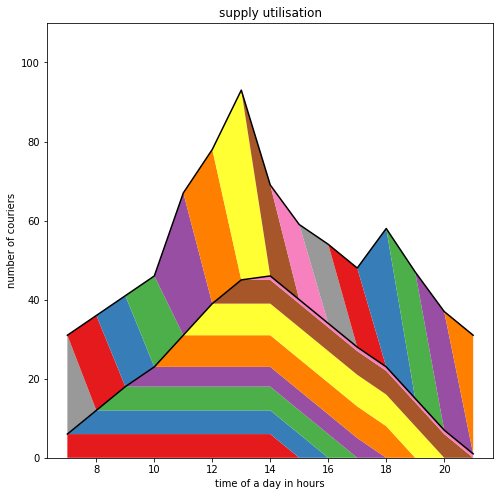

In [164]:
plot(solve(np.add(idle, busy)))

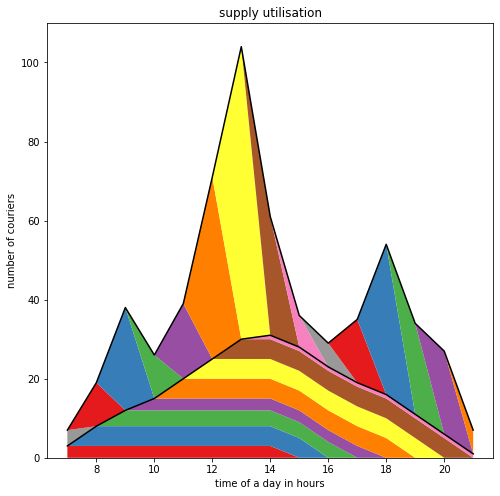

In [165]:
plot(solve(optimal))